<a href="https://colab.research.google.com/github/sergiomelman/4linux-HandsOn-Flask-App/blob/main/Regress%C3%A3o_WebMotors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória e Regressão Linear com dados de Carros

Descrição do Projeto: Projeto de Regressão Linear para estimar o valor de automóveis no Brasil.

## Importando Bibliotecas

In [ ]:
#!pip install missingpy

In [ ]:
# Básicas Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# Expressões Regulares
import re

# Estatística
import statsmodels.api as sm
from scipy import stats

# Imputação de dados
import missingpy

# Scikit Learn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Pickle para Salvar Modelo
import pickle

## Carregando o arquivo

In [ ]:
# Carregar as primeiras 5 linhas do Dataset
df = pd.read_csv('/content/webmotors.csv', encoding='ISO-8859-1' , nrows=5)

In [ ]:
# Visualizando o dataset
df

,Automóvel,Descrição,Automático,Ano,Km,Local,Anunciante,Preço
0,MERCEDES-BENZ GLE 350,3.0 V6 BLUETEC DIESEL SPORT 4MATIC 9G-TRONIC,Y,2017/2017,87940 km,Campinas - SP,Concessionária,R$ 299400
1,AUDI A1,1.4 TFSI SPORTBACK ATTRACTION 16V 122CV GASOLI...,Y,2016/2017,40524 km,Campinas - SP,Concessionária,R$ 96900
2,AUDI RS Q8,4.0 V8 GASOLINA TWINTURBO MHEV TIPTRONIC,Y,2021/2021,9925 km,Campinas - SP,Concessionária,R$ 1190000
3,BMW X4,3.0 TWINPOWER GASOLINA M40I STEPTRONIC,Y,2018/2019,20000 km,Fortaleza - CE,Loja,R$ 429900
4,LEXUS NX 300h,2.5 16V VVT-I HYBRID LUXURY CVT AWD,Y,2019/2020,4800 km,Fortaleza - CE,Loja,R$ 279900


Após o contato inicial com o dataset, observa-se que a coluna 'Km' possui as letras *km* após os números e a coluna preço traz pontos para marcação de milhar, além da denotação da moeda Real.
É necessário remover esses caracteres para que o Pandas consiga inferir corretamente o tipo de dados naquela coluna.
Vamos criar duas funções *lambda* para essa tarefa e carregar o dataset completo.

In [ ]:
# Criando dois parsers para limpar as colunas Km e Preço
parse_price = lambda x: x[3:]
parse_km = lambda x: x[:-2]

# Reimportando o dataset
df = pd.read_csv('/content/webmotors.csv',
                 encoding='ISO-8859-1',
                 converters= {'Km': parse_km,
                              'Preço': parse_price})
df

,Automóvel,Descrição,Automático,Ano,Km,Local,Anunciante,Preço
0,MERCEDES-BENZ GLE 350,3.0 V6 BLUETEC DIESEL SPORT 4MATIC 9G-TRONIC,Y,2017/2017,87940,Campinas - SP,Concessionária,299400
1,AUDI A1,1.4 TFSI SPORTBACK ATTRACTION 16V 122CV GASOLI...,Y,2016/2017,40524,Campinas - SP,Concessionária,96900
2,AUDI RS Q8,4.0 V8 GASOLINA TWINTURBO MHEV TIPTRONIC,Y,2021/2021,9925,Campinas - SP,Concessionária,1190000
3,BMW X4,3.0 TWINPOWER GASOLINA M40I STEPTRONIC,Y,2018/2019,20000,Fortaleza - CE,Loja,429900
4,LEXUS NX 300h,2.5 16V VVT-I HYBRID LUXURY CVT AWD,Y,2019/2020,4800,Fortaleza - CE,Loja,279900
...,...,...,...,...,...,...,...,...
1347,CITROËN C4 CACTUS,1.6 VTI 120 FLEX FEEL EAT6,Y,2019/2020,44287,São Paulo - SP,Loja,78900
1348,JEEP RENEGADE,1.8 16V FLEX SPORT 4P AUTOMÁTICO,Y,2017/2018,34000,São Paulo - SP,Loja,80000
1349,VOLKSWAGEN T-CROSS,1.0 200 TSI TOTAL FLEX COMFORTLINE AUTOMÁTICO,Y,2019/2020,20500,São Paulo - SP,Concessionária,106900
1350,CHERY TIGGO 5x,1.5 VVT TURBO iFLEX TXS DCT,Y,2019/2020,19000,São Paulo - SP,Concessionária,106900


A fim de manter os dados originais intactos (caso precisemos retornar a eles ou comparar algo), vamos criar uma nova variável para nosso dataset.

In [ ]:
# Cria cópia do dataset
carros = df.copy()

## Formatando o Dataset

O objetivo de formatar os dados após a importação é para que tenhamos um conjunto homogêneo e que nos forneça o máximo de informações possíveis.
É nessa etapa que vamos criar novas variáveis, remover aquelas que não nos interessa, renomeá-las para facilitar o código, limpar valores sem sentido e verificar a existência de dados faltantes.

In [ ]:
# Vou renomear as colunas para facilitar o código
carros.columns = ['car', 'descricao', 'automatico', 'ano', 'km', 'local', 'anunciante', 'preco']

Usando o str.split do Pandas, eu posso indicar um caracter que separa as informações, criando, deste modo, novas colunas. Veja na próxima célula como é a saída desse método e, em seguida, como ele pode ser usado para criar novas variáveis importantes.

In [ ]:
# Usando o str.split, eu posso indicar ao Pandas para separar a coluna por " - " 
carros.local.str.split(" - ", expand = True).head(2)

,0,1
0,Campinas,SP
1,Campinas,SP


In [ ]:
# Criar colunas de Estado, Cidade, Fabricante, ano de fabrica e ano de modelo 
carros['cidade'] = carros.local.str.split(" - ", expand = True)[0]
carros['estado'] = carros.local.str.split(" - ", expand = True)[1]
carros['fabricante'] = carros.car.str.split(" ", expand = True)[0]
carros['ano_fabrica'] = carros.ano.str.split("/", expand = True)[0]
carros['ano_modelo'] = carros.ano.str.split("/", expand = True)[1]
# Remove coluna "Local" e coluna "Ano"
carros.drop(['ano','local'], axis=1, inplace=True)

Logo que criamos novas variáveis, é necessário verificar se os valores fazem sentido. Uma boa opção é imprimir os valores únicos, a fim de procurar por valores que não fazem sentido. 

Veja que, para fabricante, precisamos alterar RAM para Dodge e LAND para Land Rover, bem como remover o acento de Citroen.

In [ ]:
# Verificando se os valores fazem sentido
carros.fabricante.unique()

array(['MERCEDES-BENZ', 'AUDI', 'BMW', 'LEXUS', 'LAND', 'PORSCHE', 'JEEP',
       'VOLVO', 'JAGUAR', 'HYUNDAI', 'VOLKSWAGEN', 'KIA', 'MITSUBISHI',
       'RENAULT', 'FORD', 'CHEVROLET', 'NISSAN', 'PEUGEOT', 'HONDA',
       'FIAT', 'CITROËN', 'TOYOTA', 'CHERY', 'SUZUKI', 'DODGE', 'RAM',
       'MINI', 'JAC', 'LIFAN'], dtype=object)

In [ ]:
# Transformação
carros.fabricante.replace({'LAND':'LAND ROVER', 'RAM': 'DODGE', 'CITROËN': 'CITROEN'}, inplace=True)
carros.fabricante.unique()

array(['MERCEDES-BENZ', 'AUDI', 'BMW', 'LEXUS', 'LAND ROVER', 'PORSCHE',
       'JEEP', 'VOLVO', 'JAGUAR', 'HYUNDAI', 'VOLKSWAGEN', 'KIA',
       'MITSUBISHI', 'RENAULT', 'FORD', 'CHEVROLET', 'NISSAN', 'PEUGEOT',
       'HONDA', 'FIAT', 'CITROEN', 'TOYOTA', 'CHERY', 'SUZUKI', 'DODGE',
       'MINI', 'JAC', 'LIFAN'], dtype=object)

In [ ]:
# Outras verificações
carros.cidade.unique()
carros.estado.unique()

array(['SP', 'CE', 'SC', 'MG', 'PR', 'DF', 'RJ', 'RS', 'GO', 'ES', 'BA',
       'PB', 'PE', 'MS', 'AM', 'MA', 'PA', 'PI', 'MT', 'RN', 'RO', 'AL',
       'TO'], dtype=object)

A fim de simplificar o modelo, vamos transformar a coluna de estado em Macro-Regiões

In [ ]:
# Mapear macro regiões
carros['regiao'] = carros.estado.map({'SP': 'Sudeste', 'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste',
                                      'CE': 'Nordeste', 'BA':'Nordeste', 'MA':'Nordeste', 'PI':'Nordeste','AL':'Nordeste', 'PB':'Nordeste', 'PE':'Nordeste','RN':'Nordeste',
                                      'SC':'Sul', 'PR': 'Sul', 'RS': 'Sul', 
                                      'GO': 'Centro-Oeste','DF':'Centro-Oeste','MS': 'Centro-Oeste','MT': 'Centro-Oeste',
                                      'AM': 'Norte', 'PA': 'Norte','RO':'Norte','TO':'Norte'})

Constantemente imprimimos poucas linhas dos nossos dados para que tenhamos certeza de que as transformações estão ocorrendo da maneira esperada. A prática, entretanto, não é necessária. Apenas uma prática de minha preferência.

Notebooks são ótimas ferramentas para compartilharmos nossa na análise com outros Cientistas de Dados, mas certamente que essas células de visualização podem ser removidas caso precise.

In [ ]:
# Visualizar a transformação
carros.head(1)

,car,descricao,automatico,km,anunciante,preco,cidade,estado,fabricante,ano_fabrica,ano_modelo,regiao
0,MERCEDES-BENZ GLE 350,3.0 V6 BLUETEC DIESEL SPORT 4MATIC 9G-TRONIC,Y,87940,Concessionária,299400,Campinas,SP,MERCEDES-BENZ,2017,2017,Sudeste


Em seguida, criamos uma função para extrair apenas as palavras relativas ao tipo de combustível do automóvel e colocamos em uma coluna. Depois, repetimos a verificação de valores únicos e alteramos o necessário.

In [ ]:
# Usando expressão regular e uma função, vamos extrair o tipo de combustível da descrição
def combustivel(text):
  if len( re.findall(r'\bDIESEL|GASOLINA|FLEX|FLEXSTART|HYBRID|HÍBRIDO|ELÉTRICO\b', text) ) == 0:
    return np.nan
  else:
    return re.findall(r'\bDIESEL|GASOLINA|FLEX|FLEXSTART|HYBRID|HÍBRIDO|ELÉTRICO\b', text)[0]

# Aplicando a funçao
carros['combustivel'] = carros.descricao.apply( combustivel )

# Verificando valores únicos
carros.combustivel.unique()

array(['DIESEL', 'GASOLINA', 'HYBRID', 'HÍBRIDO', 'FLEX', 'ELÉTRICO'],
      dtype=object)

In [ ]:
# Vamos substituir 'HYBRID' por 'HÍBRIDO' para padronizar
carros.combustivel.replace({'HYBRID':'HÍBRIDO'}, inplace=True)
carros.combustivel.unique()

array(['DIESEL', 'GASOLINA', 'HÍBRIDO', 'FLEX', 'ELÉTRICO'], dtype=object)

In [ ]:
# Criando nova coluna para Potência do Motor
carros['motor'] = carros.descricao.str.split(" ", expand = True)[0]
carros['motor'].unique()

array(['3.0', '1.4', '4.0', '2.5', '1.3', '2.0', '1.6', '2.2', '1.8',
       '2.9', '3.3', '3.6', '3.8', '4.4', '1.5', '1.0', '1.2', 'ELÉTRICO',
       '90', '2.8', '2.7', '6.7', '3.2', '2.4', '2.3', '5.0', '3.5'],
      dtype=object)

In [ ]:
# Verificando as observações problemáticas
carros.query('motor == "90" | motor == "ELÉTRICO"')

,car,descricao,automatico,km,anunciante,preco,cidade,estado,fabricante,ano_fabrica,ano_modelo,regiao,combustivel,motor
343,AUDI E-TRON,ELÉTRICO SPORTBACK PERFORMANCE BLACK QUATTRO,Y,0,Concessionária,647590,Londrina,PR,AUDI,2021,2021,Sul,ELÉTRICO,ELÉTRICO
362,JAGUAR I-PACE,90 KW EV400 SE AWD ELÉTRICO,Y,0,Concessionária,651950,Campinas,SP,JAGUAR,2021,2021,Sudeste,ELÉTRICO,90
530,AUDI E-TRON,ELÉTRICO SPORTBACK PERFORMANCE BLACK QUATTRO,Y,0,Concessionária,693690,Campinas,SP,AUDI,2021,2021,Sudeste,ELÉTRICO,ELÉTRICO
865,JAC IEV40,ELÉTRICO AUTOMÁTICO,Y,15000,Pessoa Física,165000,Florianópolis,SC,JAC,2019,2020,Sul,ELÉTRICO,ELÉTRICO
906,AUDI E-TRON,ELÉTRICO PERFORMANCE BLACK QUATTRO,Y,3700,Pessoa Física,559000,Itapema,SC,AUDI,2020,2020,Sul,ELÉTRICO,ELÉTRICO


Iremos descartar essas 6 observações acima por esses motivos:
* São carros elétricos, logo não sabemos como atribuir um valor para o motor que seja compatível com os outros carros.
* São carros 0km, mas nosso foco é maior em carros usados.
* É uma decisão do Cientista de Dados, visto que são poucos dados que trariam mais complicação do que benefício.

In [ ]:
# Removendo linhas pelo número do índice
carros.drop([343, 362, 530, 865, 906], axis=0, inplace=True)

In [ ]:
# Remover a coluna descrição
carros.drop('descricao', axis=1, inplace=True)

In [ ]:
# Mapear variável 'automatico' para 0 e 1
carros['automatico'] = carros.automatico.map({'Y':1, 'N':0})

In [ ]:
# Verificando a existência de dados NA
carros.isnull().sum()

car            0
automatico     0
km             0
anunciante     0
preco          0
cidade         0
estado         0
fabricante     0
ano_fabrica    0
ano_modelo     0
regiao         0
combustivel    0
motor          0
dtype: int64

In [ ]:
# Shape do dataset limpo 
carros.shape

(1347, 13)

In [ ]:
# Reordenando colunas
ordem = ['car', 'fabricante', 'motor', 'combustivel', 'automatico', 'ano_fabrica', 'ano_modelo', 'km', 'anunciante', 'cidade', 'estado','regiao','preco']

carros = carros.reindex(columns= ordem)

In [ ]:
# Verificando os tipos de variáveis
carros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1351
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   car          1347 non-null   object
 1   fabricante   1347 non-null   object
 2   motor        1347 non-null   object
 3   combustivel  1347 non-null   object
 4   automatico   1347 non-null   int64 
 5   ano_fabrica  1347 non-null   object
 6   ano_modelo   1347 non-null   object
 7   km           1347 non-null   object
 8   anunciante   1347 non-null   object
 9   cidade       1347 non-null   object
 10  estado       1347 non-null   object
 11  regiao       1347 non-null   object
 12  preco        1347 non-null   object
dtypes: int64(1), object(12)
memory usage: 147.3+ KB


Vamos ver se as variáveis tem os tipos de dados corretos e alterar onde for necessário.
 *   *car*         : Não altera.
 *   *fabricante*  : Não altera.
 *   *motor*       : Altera para: **float**
 *   *combustivel* : Altera para: **Categórico**
 *   *automatico*  : Altera para: **integer**
 *   *ano_fabrica* : Altera para: **integer**
 *   *ano_modelo*  : Altera para: **integer**
 *   *km*          : Altera para: **integer**
 *   *anunciante*  : Não altera.
 *   *cidade*      : Não altera.
 *  *estado*       : Não altera.
*   *regiao* : Altera para: **Categórico**
 *  *preco*        : Altera para: **float**

In [ ]:
# Cria dicionário com o nome da coluna e o tipo de dado
data_types = {'motor':'float',
              'combustivel':'category',
              'automatico':'int',
              'ano_fabrica':'int',
              'ano_modelo':'int',
              'km':'int',
              'regiao': 'category',
              'preco':'float'}


carros = carros.astype(data_types)
carros.dtypes

car              object
fabricante       object
motor           float64
combustivel    category
automatico        int64
ano_fabrica       int64
ano_modelo        int64
km                int64
anunciante       object
cidade           object
estado           object
regiao         category
preco           float64
dtype: object

In [ ]:
carros.head(1)

,car,fabricante,motor,combustivel,automatico,ano_fabrica,ano_modelo,km,anunciante,cidade,estado,regiao,preco
0,MERCEDES-BENZ GLE 350,MERCEDES-BENZ,3.0,DIESEL,1,2017,2017,87940,Concessionária,Campinas,SP,Sudeste,299400.0


In [ ]:
# Reset do índice
carros.reset_index(drop=True, inplace=True)

In [ ]:
# Salva dataset formatado
carros.to_csv('carros.csv', encoding='ISO 8859-1')

## Análise Exploratória e Visualizações

Nesta etapa, devemos explorar os dados de modo a extrair os primeiros insights, procurar por boas correlações, analisar se há alguma inconsistência e abrir caminho para a escolha das melhores variáveis para o nosso modelo de regressão linear.

Os primeiros passos, para mim, são sempre a verificação estatística descritiva e os histogramas. Com tais pontos, teremos uma noção de como o conjunto de dados está distribuído.

### Estatística Descritiva

In [ ]:
# Describe traz todas os indicadores estatísticos descritivos para valores numéricos
carros.describe().round(2)

,motor,automatico,ano_fabrica,ano_modelo,km,preco
count,1347.00,1347.00,1347.00,1347.0,1347.00,1347.0
mean,1.67,0.65,2017.98,2018.6,43661.53,125088.9
std,0.79,0.48,2.38,2.4,50831.59,129611.9
min,1.00,0.00,2008.00,2008.0,0.00,17500.0
25%,1.00,0.00,2017.00,2018.0,15000.00,52900.0
50%,1.60,1.00,2019.00,2019.0,36300.00,82490.0
75%,2.00,1.00,2019.00,2020.0,60850.00,138400.0
max,6.70,1.00,2022.00,2022.0,999999.00,1350000.0


In [ ]:
# Estatísticas para valores categóricos
carros.describe(include=['object','category'])

,car,fabricante,combustivel,anunciante,cidade,estado,regiao
count,1347,1347,1347,1347,1347,1347,1347
unique,171,28,4,3,269,23,5
top,CHEVROLET ONIX,CHEVROLET,FLEX,Loja,São Paulo,SP,Sudeste
freq,125,215,1011,711,238,637,857


**I n s i g h t s**:
* Média de potência do motor: 1.7
* Média KM: 43.6k, porém com desvio padrão bem alto [50k], indicando outliers.
 - O valor máximo de KM é suspeito.
* Média de preço é ~R$125k, mas os dados também parecem dispersos. A verificar.
* Chevrolet Onix é o carro mais anunciado neste dataset.
* Carros da GM são os mais anunciados.
* Os anúncios tem a maioria de carros compactos, flex, automáticos e de fabricação recente.
* Lojas são as maiores anunciantes neste conjunto de dados.
* São Paulo lidera na quantidade anúncios.


### Histogramas

''

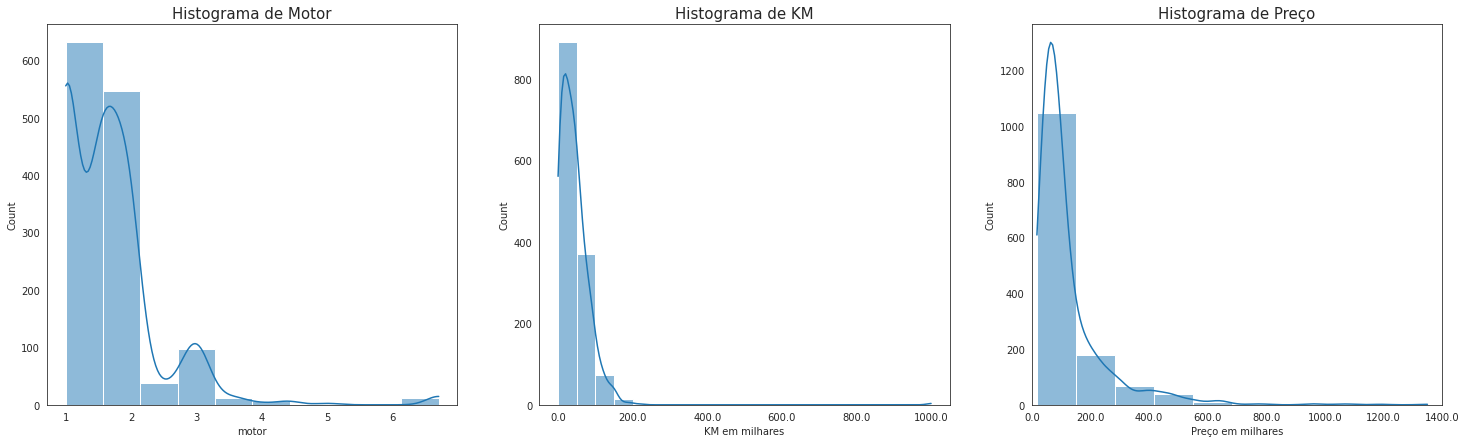

In [ ]:
# Plotando histogramas
fig, (g1, g2, g3) = plt.subplots(nrows=1, ncols=3, figsize=(25,7))

g1 = sns.histplot(carros, x='motor', bins=10, kde=True, ax=g1)
g1.set_title('Histograma de Motor', size=15)

g2 = sns.histplot(carros, x='km', bins=20, kde=True, ax=g2)
g2.set_title('Histograma de KM', size=15)
g2.set_xticklabels(g2.get_xticks()/1000) # retorna os valores do eixo x dividido por 1000
g2.set_xlabel('KM em milhares')

g3 = sns.histplot(carros, x='preco', bins=10, kde=True, ax=g3)
g3.set_title('Histograma de Preço', size=15)
plt.xticks(g3.get_xticks(), g3.get_xticks()/1000) # retorna os valores do eixo x dividido por 1000
plt.xlim((0,1400000))
g3.set_xlabel('Preço em milhares')

;

**Análise**:
* A maioria dos dados está concentrada em motores entre 1.0 e 2.0, reiterando o que foi demonstrado pela média.
* A quilometragem dos carros está bem concentrada na faixa entre 0 e 50 mil km nesse dataset.
* O número de automóveis cai exponencialmente à medida em que aumenta o preço.

### Análises Univariadas

As análises univariadas são úteis para que possamos extrair bons insights do dataset ao olhar para uma variável de cada vez.

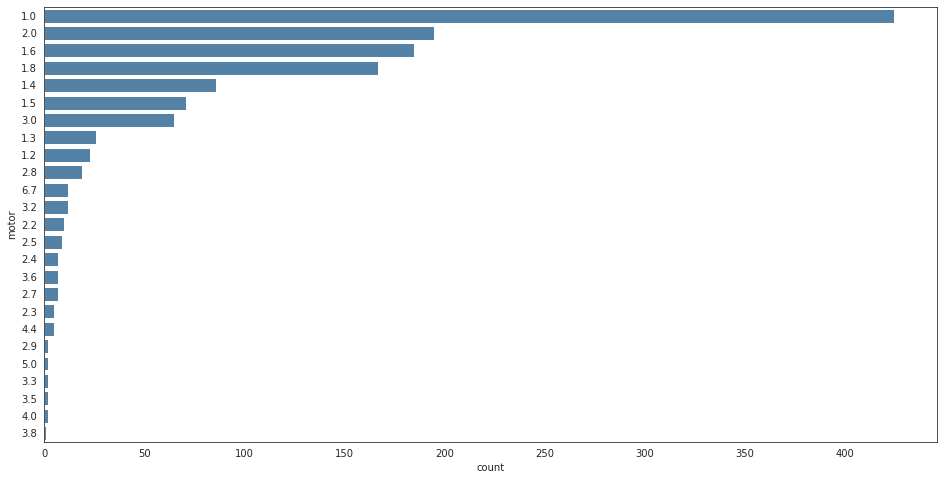

In [ ]:
# Cria figura para customizar tamanho do gráfico
plt.figure(figsize=(16,8))
# Cria ordem das barras 
ordem = carros.groupby('motor').motor.count().sort_values(ascending=False).index
# Count Plot Motor
sns.countplot(y='motor', data=carros, color='steelblue', order=ordem );

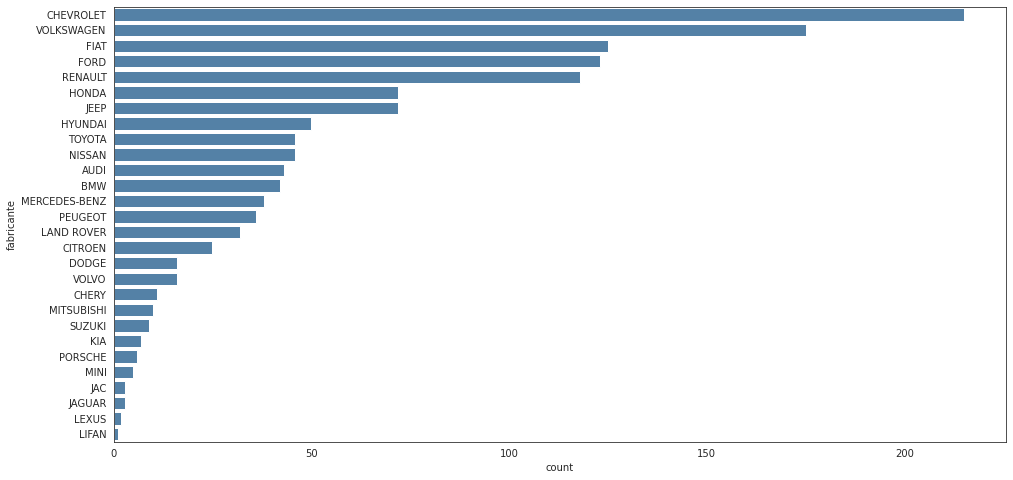

In [ ]:
# Cria figura para customizar tamanho do gráfico
plt.figure(figsize=(16,8))
# Cria ordem das barras 
ordem = carros.groupby('fabricante').motor.count().sort_values(ascending=False).index
# Count Plot
sns.countplot(y='fabricante', data=carros, color='steelblue', order=ordem );

As 5 montadoras mais populares neste dataset (GM, VW, Renault, Ford e FIAT) são as que vendem carros mais populares.

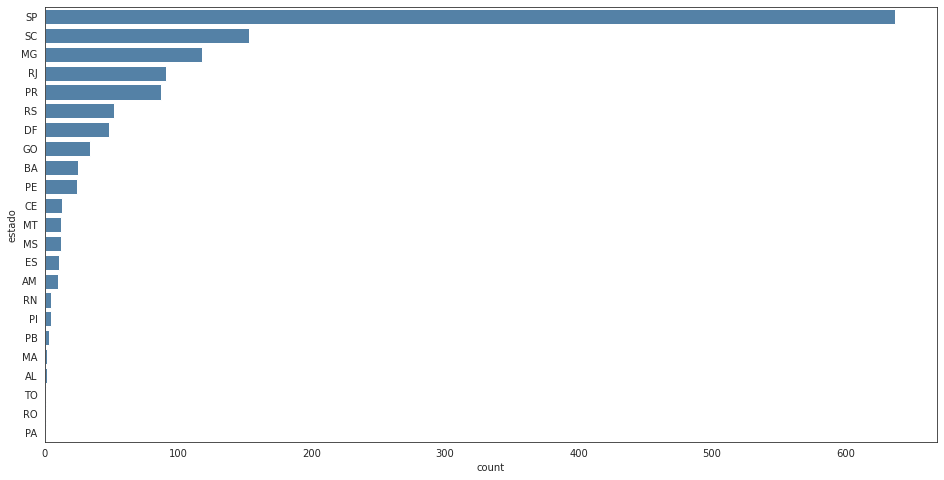

In [ ]:
# Cria figura para customizar tamanho do gráfico
plt.figure(figsize=(16,8))
# Cria ordem das barras 
ordem = carros.groupby('estado').motor.count().sort_values(ascending=False).index
# Count Plot
sns.countplot(y='estado', data=carros, color='steelblue', order=ordem );

O estado mais rico e populoso do país tem a maioria dos anúncios. Faz sentido.

''

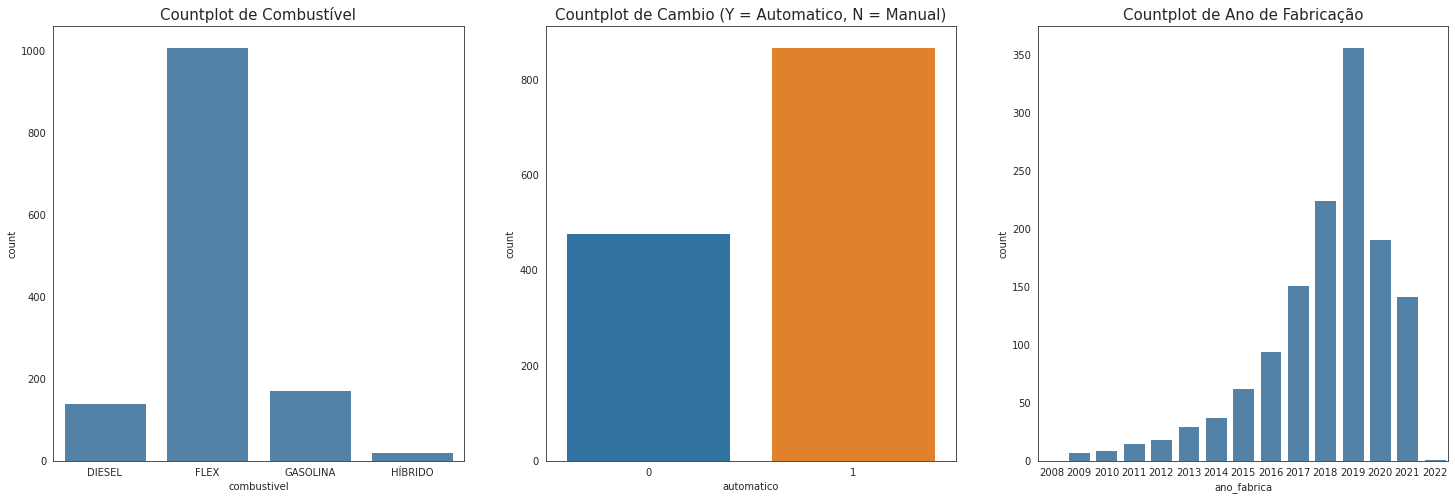

In [ ]:
# Cria figura para customizar tamanho do gráfico
fig, g = plt.subplots(1,3, figsize=(25,8))

g1 = sns.countplot(data=carros, x='combustivel', color='steelblue', ax=g[0])
g1.set_title('Countplot de Combustível', size=15)

g2 = sns.countplot(data=carros, x='automatico', ax=g[1])
g2.set_title('Countplot de Cambio (Y = Automatico, N = Manual)', size=15)

g3 = sns.countplot(data=carros, x='ano_fabrica', color='steelblue', ax=g[2])
g3.set_title('Countplot de Ano de Fabricação', size=15)
;

In [ ]:
# Fabricado em 2022 não faz sentido.
carros.query('ano_fabrica == 2022')

,car,fabricante,motor,combustivel,automatico,ano_fabrica,ano_modelo,km,anunciante,cidade,estado,regiao,preco
433,FORD RANGER,FORD,2.2,DIESEL,1,2022,2022,0,Loja,Santa Cruz do Sul,RS,Sul,209900.0
1090,FIAT ARGO,FIAT,1.3,FLEX,0,2022,2022,900,Pessoa Física,São Paulo,SP,Sudeste,78000.0


In [ ]:
# Corrigir para 2021
carros.ano_fabrica.replace({2022:2021}, inplace=True)

Os dados seguem coerentes. Tecnologia Flex é muito forte no Brasil e os carros automáticos ganham cada vez mais mercado. Sabendo que os anúncios são majoritariamente de SP, também faz sentido que ver o ano de fábrica mais recente, pois o mercado de revenda gira mais no estado. 

''

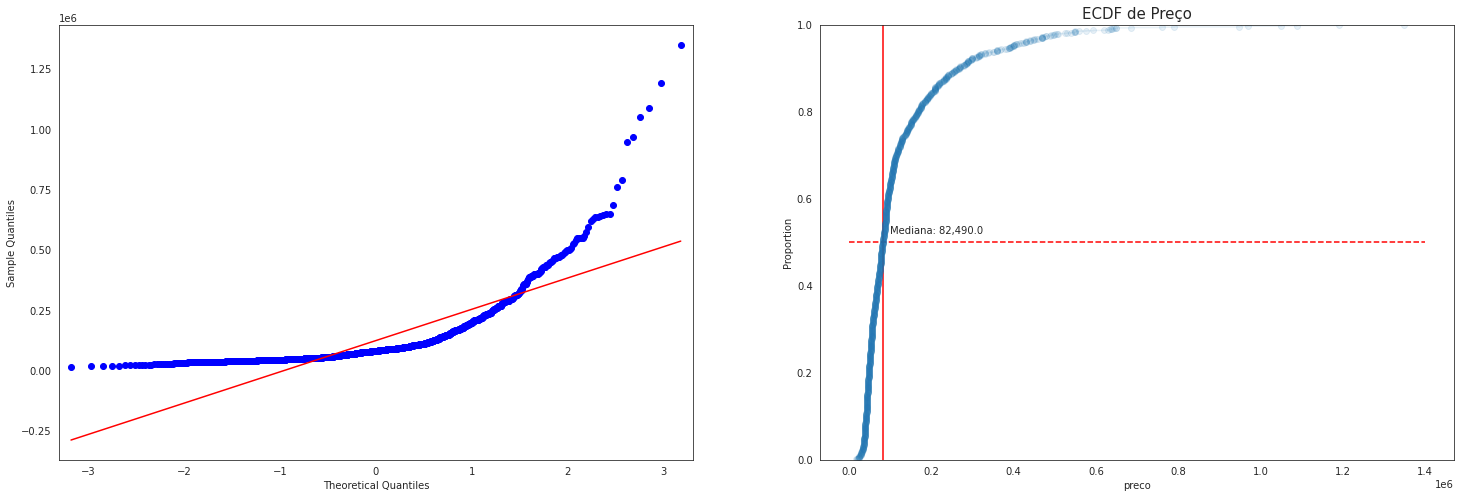

In [ ]:
# QQPlot e ECDF de Preço

# Cria figura para customizar tamanho do gráfico
fig, g = plt.subplots(1,2, figsize=(25,8))

g1 = sm.qqplot(carros.preco, line='s', ax=g[0])

g2 = sns.ecdfplot(data=carros, x='preco', marker='o', alpha=0.1, ax=g[1])
g2.set_title('ECDF de Preço', size=15)
# Linhas nos 50% dos dados
mediana = carros.preco.median() # mediana
g2 = plt.hlines(y=0.5, xmin=-1000, xmax=1400000, colors='red', linestyles='--') # linha horizontal
g2 = plt.vlines(x=mediana, ymin=0, ymax=1, colors='red') #linha vertical
g2 = plt.annotate(f'Mediana: {mediana:,}', xy=(mediana+17000, 0.52)) # anotação do valor da mediana
;

''

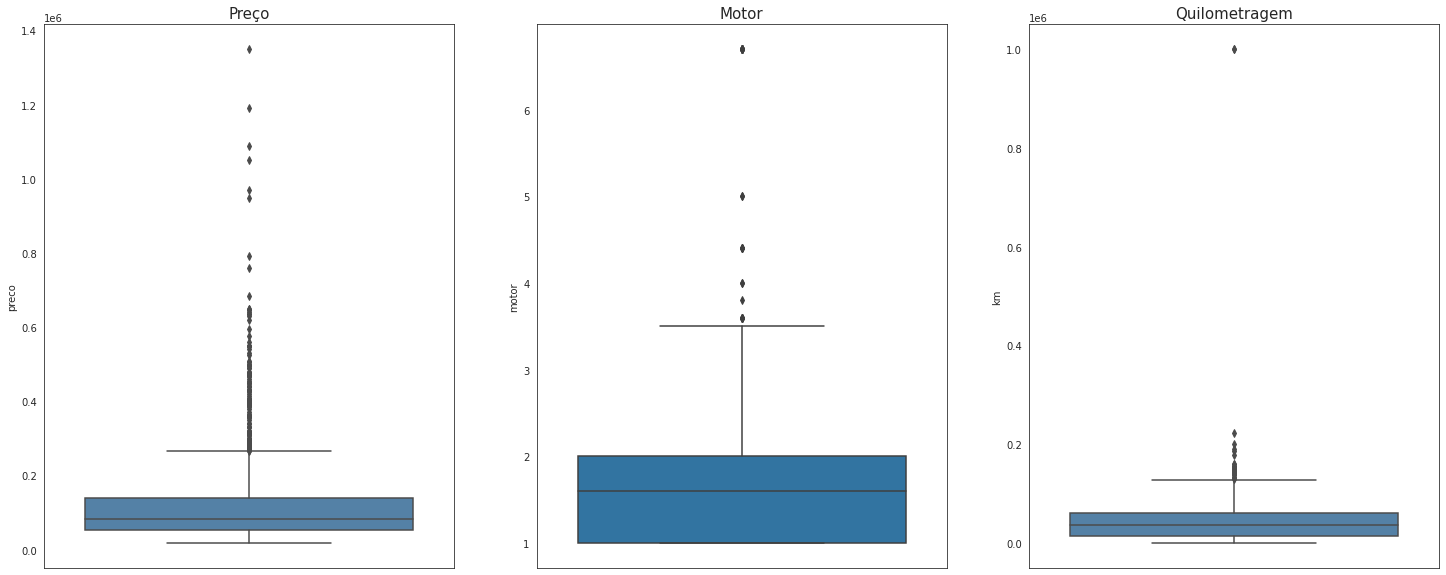

In [ ]:
# Boxplots
fig, g = plt.subplots(1,3, figsize=(25,10))

g1 = sns.boxplot(data=carros, y='preco', color='steelblue', ax=g[0])
g1.set_title('Preço', size=15)

g2 = sns.boxplot(data=carros, y='motor', ax=g[1])
g2.set_title('Motor', size=15)

g3 = sns.boxplot(data=carros, y='km', color='steelblue', ax=g[2])
g3.set_title('Quilometragem', size=15)
;

Dos gráficos de [QQ Plot](https://www.geeksforgeeks.org/qqplot-quantile-quantile-plot-in-python/), ECDF e boxplots, percebemos que as variáveis tem outliers, os quais podem precisar de algum tratamento antes da modelagem.
Veja como aquele valor suspeito (provavelmente errôneo) encurta o boxplot de KM.

In [ ]:
# Teste de normalidade dos preços (variável target)
_, p_value = stats.normaltest(carros.preco)
print(f'-- Resultado do teste -- \np-Value dos preços: {p_value.round()} < 0.05 \nPortanto, há evidência estatística para rejeitar a normalidade da variável Preço.')

-- Resultado do teste -- 
p-Value dos preços: 0.0 < 0.05 
Portanto, há evidência estatística para rejeitar a normalidade da variável Preço.


*Os dados da variável target não são normais. Isso faz diferença?*

Para casos de regressão linear, não. O que deve ser normalmente distribuído é a distribuição dos erros de predição.
Leitura recomendada: https://tinyurl.com/783k3a63

### Análises Bivariadas

As análises bivariadas são úteis para compararmos variáveis e entender a relação entre elas. Vamos ver como as variáveis independentes se relacionam com os preços.

In [ ]:
# Tabela de correlação
corr_ = carros.corr(method='spearman')

pd.DataFrame(corr_).style.background_gradient(cmap='coolwarm')

,motor,automatico,ano_fabrica,ano_modelo,km,preco
motor,1.000000,0.608790,-0.046801,-0.059842,-0.068916,0.665538
automatico,0.608790,1.000000,0.127005,0.111566,-0.266539,0.678167
ano_fabrica,-0.046801,0.127005,1.000000,0.963565,-0.763446,0.452068
ano_modelo,-0.059842,0.111566,0.963565,1.000000,-0.757001,0.436947
km,-0.068916,-0.266539,-0.763446,-0.757001,1.000000,-0.506247
preco,0.665538,0.678167,0.452068,0.436947,-0.506247,1.000000


Usamos o método de *Spearman* porque os preços não seguem uma relação linear, mas sim exponencial. Os resultados mostram correlação razoável entre preço e potência do motor e uma relação moderada entre ano de fabricação e quilometragem com o valor do automóvel.

''

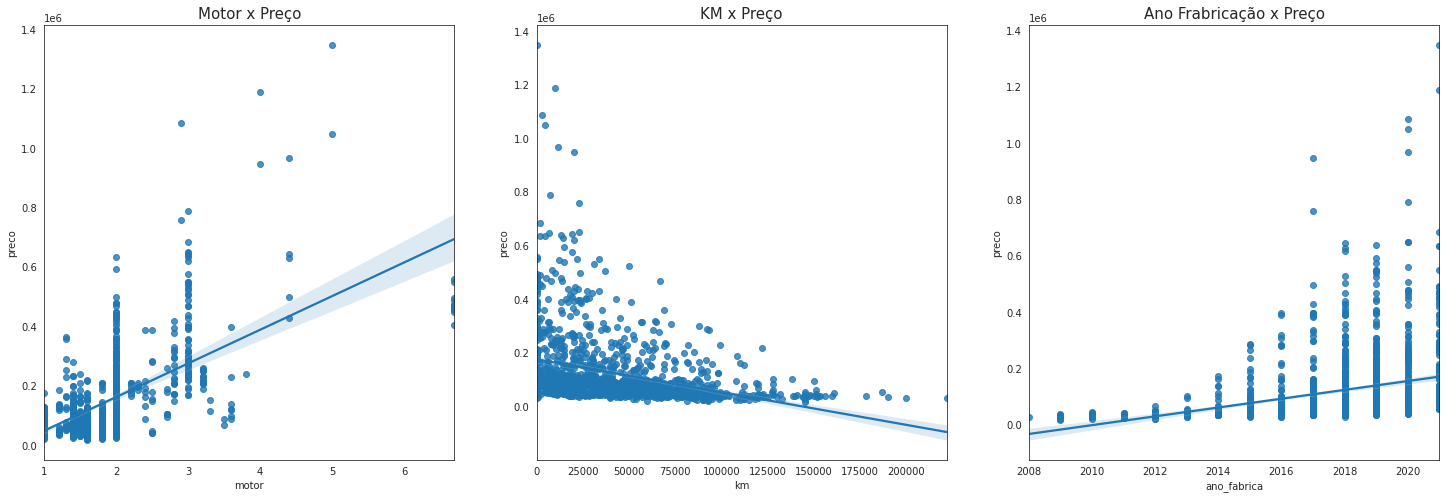

In [ ]:
# Cria figura para customizar tamanho do gráfico
fig, g = plt.subplots(1,3, figsize=(25,8))

# Plot dos gráficos de dispersão
g1 = sns.regplot(data=carros, x='motor', y='preco', ax=g[0])
g1.set_title('Motor x Preço', size=15)

g2 = sns.regplot(data=carros.query('km <= 700000'), x='km', y='preco', ax=g[1]) # filtro sem outlier 999,999
g2.set_title('KM x Preço', size=15)

g3 = sns.regplot(data=carros, x='ano_fabrica', y='preco', ax=g[2])
g3.set_title('Ano Frabricação x Preço', size=15)
;

A seguir, vamos plotar os gráficos das variáveis categóricas em relação ao preço.

''

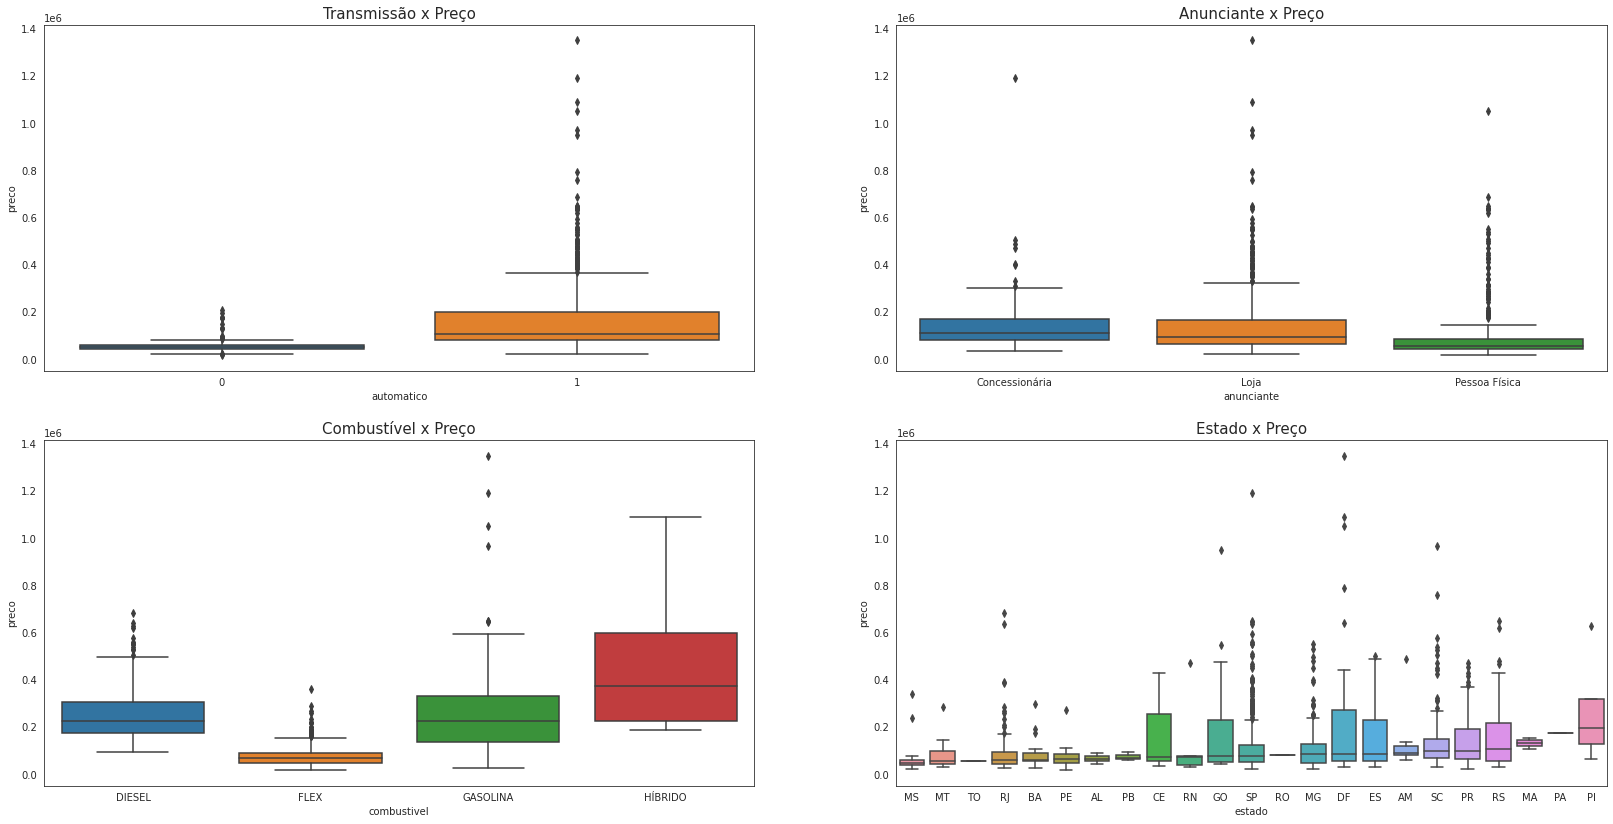

In [ ]:
# Cria figura para customizar tamanho do gráfico
fig, g = plt.subplots(2,2, figsize=(28,14))

# Plot dos gráficos

# Preços por tipo de transmissão
g1 = sns.boxplot(data=carros, x='automatico', y='preco', ax=g[0][0])
g1.set_title('Transmissão x Preço', size=15)

# Preços por Anunciante
g2 = sns.boxplot(data=carros, x='anunciante', y='preco', ax=g[0][1])
g2.set_title('Anunciante x Preço', size=15)

# Combistível x Preço
g3 = sns.boxplot(data=carros, x='combustivel', y='preco', ax=g[1][0])
g3.set_title('Combustível x Preço', size=15)

# Estado x Preço
ordem = carros.groupby('estado').preco.median().sort_values().index
g3 = sns.boxplot(data=carros, x='estado', y='preco', order=ordem, ax=g[1][1])
g3.set_title('Estado x Preço', size=15)
;

In [ ]:
# Preços por Tipo de Câmbio
carros.groupby('automatico').preco.agg(['mean', 'std'])

,mean,std
automatico,,
0,54116.912134,21089.948513
1,164127.570771,146650.594961


In [ ]:
# Preços por Tipo de anunciante
carros.groupby('anunciante').preco.agg(['mean', 'std'])

,mean,std
anunciante,,
Concessionária,144299.757962,121775.830999
Loja,141401.306610,135855.714027
Pessoa Física,94579.022965,116621.558563


In [ ]:
# Preços por Região
carros.groupby('regiao').preco.agg(['mean', 'std', 'count']).sort_values(by='mean' , ascending=False)

,mean,std,count
regiao,,,
Centro-Oeste,176273.207547,235801.323465,106
Sul,145831.578767,131454.293910,292
Norte,125986.153846,114244.679857,13
Sudeste,113418.910152,108575.679886,857
Nordeste,106191.594937,110302.299801,79


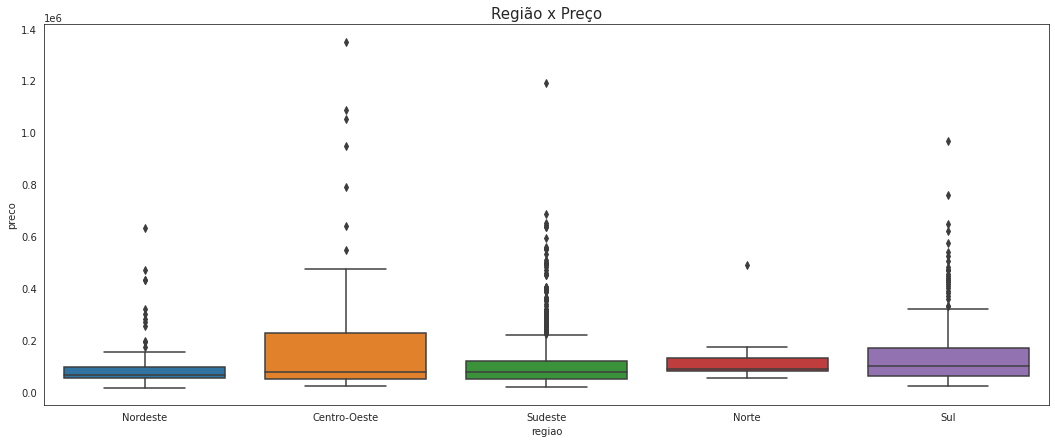

In [ ]:
# Preços por Região
plt.figure(figsize=(18,7))

# Ordem do plot
ordem = carros.groupby('regiao').preco.median().sort_values().index

g2 = sns.boxplot(data=carros, x='regiao', y='preco', order=ordem)
g2.set_title('Região x Preço', size=15)
plt.show()

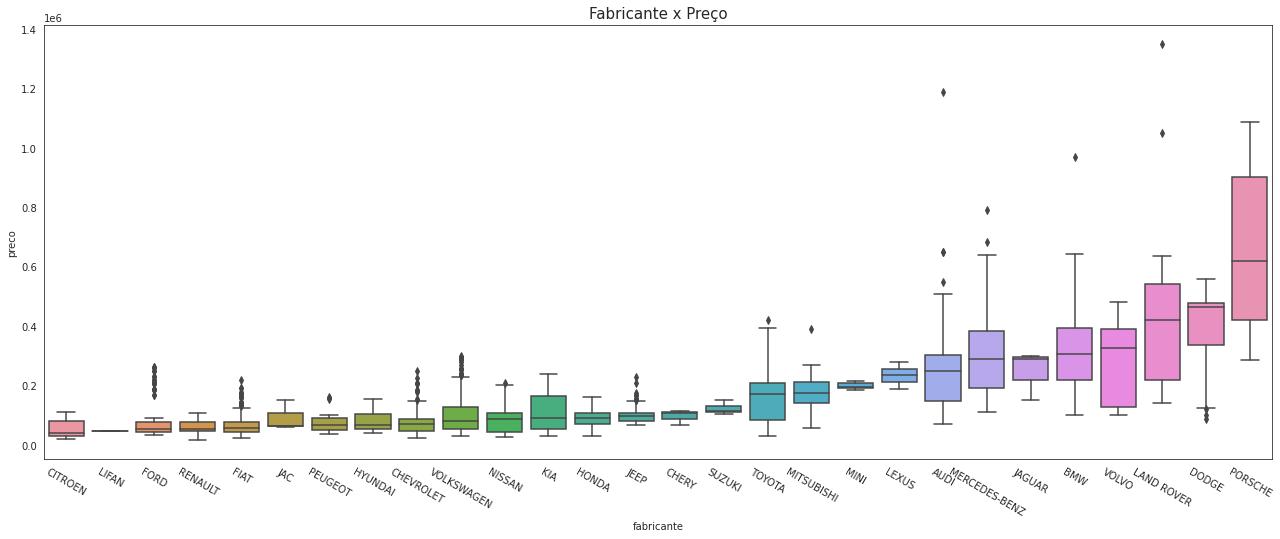

In [ ]:
# Preços por Fabricante
plt.figure(figsize=(22,8))

# Ordem do plot
ordem = carros.groupby('fabricante').preco.median().sort_values().index

g2 = sns.boxplot(data=carros, x='fabricante', y='preco', order=ordem)
g2.set_title('Fabricante x Preço', size=15)
g2.tick_params(axis='x', rotation=330)
plt.show()

Podemos ver que a marca da montadora influencia no preço, como era esperado. As marcas de carros de luxo são bem mais caras do que as outras.

## Tratamento de Outliers

Nesta fase do processo, vamos trabalhar com os outliers e/ ou erros em nosso dataset.
Nem sempre a remoção de outliers é a melhor opção. Afinal, nosso dataset pode perfeitamente ter representantes em determinada faixa de preço. Em um primeiro momento, vamos deixá-los e testar também a remoção de valores muito extremos que pode distorcer as previsãoes.

No caso deste dataset, sabemos que os carros mais caros de fato existem no mercado.

Vamos, inicialmente, tratar a coluna KM, pois essa possui um valor extremo que é possivelmente um erro.

In [ ]:
# Verificando a coluna km
carros.query('km > 200_000')

,car,fabricante,motor,combustivel,automatico,ano_fabrica,ano_modelo,km,anunciante,cidade,estado,regiao,preco
397,MITSUBISHI L200 TRITON,MITSUBISHI,2.4,DIESEL,1,2017,2017,999999,Loja,Casca,RS,Sul,163900.0
770,VOLKSWAGEN JETTA,VOLKSWAGEN,2.5,GASOLINA,1,2010,2010,999999,Loja,Pato Branco,PR,Sul,47900.0
1081,CHEVROLET ONIX,CHEVROLET,1.0,FLEX,0,2016,2016,222000,Pessoa Física,Sumaré,SP,Sudeste,31000.0


Observe que se puxarmos as observações com quilometragem maior do que 200 mil Km, temos o retorno de apenas 3 linhas. Duas delas tem o valor 999,999, o que é aparentemente uma entrada errônea, provavelmente porque o cliente não colocou aquela valor e o sistema entrou um número padrão. 

Para tratar esse valor, vamos usar ML para inputação com missing forest.

In [ ]:
# Substituir valores 999999 por NA
carros.km.replace({999999:np.nan}, inplace=True)

In [ ]:
# Instanciando o missingpy
imputer = missingpy.MissForest()

# Selecionando variáveis de entrada para previsão
X = carros.select_dtypes('number')

# Fit
X_fit = imputer.fit_transform(X)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


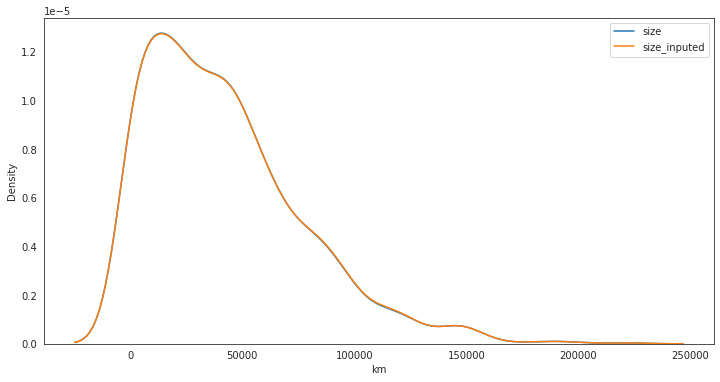

In [ ]:
# Verificando se os valores imputados modificam a distribuição dos dados
plt.figure(figsize=(12,6))
sns.kdeplot(X['km'], label='size', legend=True)
sns.kdeplot(pd.DataFrame(X_fit)[4], label='size_inputed', legend=True)
plt.legend();

In [ ]:
# Completando a alteração
carros['km'] = pd.DataFrame(X_fit)[4]
# Verificando os valores inputados
carros.iloc[[397, 770],:]

,car,fabricante,motor,combustivel,automatico,ano_fabrica,ano_modelo,km,anunciante,cidade,estado,regiao,preco
397,MITSUBISHI L200 TRITON,MITSUBISHI,2.4,DIESEL,1,2017,2017,89641.53,Loja,Casca,RS,Sul,163900.0
770,VOLKSWAGEN JETTA,VOLKSWAGEN,2.5,GASOLINA,1,2010,2010,114314.48,Loja,Pato Branco,PR,Sul,47900.0


## Preparação dos Dados para Modelagem

Vamos dividir nossos dados em treino e teste.

In [ ]:
# Dados de entrada e variável target
X = carros.drop(['car', 'cidade', 'estado', 'ano_modelo','preco'], axis=1)
y = carros.preco

In [ ]:
# One Hot Encoding as variáveis categóricas
X = pd.get_dummies(X)

In [ ]:
X.head(2)

,motor,automatico,ano_fabrica,km,fabricante_AUDI,fabricante_BMW,fabricante_CHERY,fabricante_CHEVROLET,fabricante_CITROEN,fabricante_DODGE,fabricante_FIAT,fabricante_FORD,fabricante_HONDA,fabricante_HYUNDAI,fabricante_JAC,fabricante_JAGUAR,fabricante_JEEP,fabricante_KIA,fabricante_LAND ROVER,fabricante_LEXUS,fabricante_LIFAN,fabricante_MERCEDES-BENZ,fabricante_MINI,fabricante_MITSUBISHI,fabricante_NISSAN,fabricante_PEUGEOT,fabricante_PORSCHE,fabricante_RENAULT,fabricante_SUZUKI,fabricante_TOYOTA,fabricante_VOLKSWAGEN,fabricante_VOLVO,combustivel_DIESEL,combustivel_FLEX,combustivel_GASOLINA,combustivel_HÍBRIDO,anunciante_Concessionária,anunciante_Loja,anunciante_Pessoa Física,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul
0,3.0,1,2017,87940.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,1.4,1,2016,40524.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0


Temos um dataset pequeno, com pouco mais de mil observações, logo vamos separar apenas 10% para teste.

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

In [ ]:
print(f'Shape Treino: {X_train.shape, y_train.shape} | Shape Teste: {X_test.shape, y_test.shape}')

Shape Treino: ((1212, 44), (1212,)) | Shape Teste: ((135, 44), (135,))


In [ ]:
# Criando um modelo Dummy, para comparação
dummy_model = DummyRegressor(strategy='mean')
# Treina modelo
dummy_model.fit(X_train, y_train)
pred = dummy_model.predict(X_test)
# Avalia
print( f' Score: {dummy_model.score(X_test,y_test)} \n' )

pd.DataFrame({'y':y_test,'Previsoes':pred}).head(5)

 Score: -0.0019686159751031163 



,y,Previsoes
870,42000.0,125521.941419
1187,48990.0,125521.941419
10,479900.0,125521.941419
346,92800.0,125521.941419
400,458800.0,125521.941419


## Modelos Preliminares e Escolha de Atributos

Para selecionar as melhore variáveis, um do modos de escolher as melhores variáveis é usar o próprio modelo de Regressão Linear e verificar o p-value do resultado.

In [ ]:
# Função para criar sumário de Regressão
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Métricas de regressão
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

    return [r2, mean_absolute_error, np.sqrt(mse)]

In [ ]:
# Criando um modelo de Regressão
lr = sm.OLS(y_train, X_train)

#Fit
result = lr.fit()

# Previsões
pred_regressao1 = result.predict(X_test)

# Resultado
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  preco   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     151.1
Date:                Tue, 31 Aug 2021   Prob (F-statistic):               0.00
Time:                        13:44:16   Log-Likelihood:                -14927.
No. Observations:                1212   AIC:                         2.993e+04
Df Residuals:                    1172   BIC:                         3.014e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
motor                      1.129e+05   4080.481     27.670      0.000    1.05e+05    1.21e+05
automatico                 -1.63e+04   4470.990     -3.647      0.000   -2.51e+04   -7531.645
ano_fabrica                1.274e+04   1072.655     11.875      0.000    1.06e+04    1.48e+04
km                           -0.2330      0.071     -3.281      0.001      -0.372      -0.094
fabricante_AUDI           -1.065e+06   9.89e+04    -10.763      0.000   -1.26e+06   -8.71e+05
fabricante_BMW            -1.075e+06   9.87e+04    -10.896      0.000   -1.27e+06   -8.82e+05
fabricante_CHERY          -1.175e+06   9.97e+04    -11.782      0.000   -1.37e+06   -9.79e+05
fabricante_CHEVROLET      -1.173e+06   9.85e+04    -11.908      0.000   -1.37e+06    -9.8e+05
fabricante_CITROEN        -1.183e+06   9.66e+04    -12.246      0.000   -1.37e+06   -9.94e+05
fabricante_DODGE          -1.409e+06   1.02e+05    -13.773      0.000   -1.61e+06   -1.21e+06
fabricante_FIAT           -1.192e+06   9.85e+04    -12.106      0.000   -1.39e+06   -9.99e+05
fabricante_FORD           -1.188e+06   9.82e+04    -12.103      0.000   -1.38e+06   -9.95e+05
fabricante_HONDA          -1.162e+06   9.77e+04    -11.895      0.000   -1.35e+06    -9.7e+05
fabricante_HYUNDAI        -1.199e+06   9.83e+04    -12.197      0.000   -1.39e+06   -1.01e+06
fabricante_JAC            -1.193e+06   1.02e+05    -11.742      0.000   -1.39e+06   -9.94e+05
fabricante_JAGUAR         -1.088e+06   1.02e+05    -10.704      0.000   -1.29e+06   -8.89e+05
fabricante_JEEP           -1.199e+06   9.83e+04    -12.201      0.000   -1.39e+06   -1.01e+06
fabricante_KIA            -1.232e+06   9.88e+04    -12.469      0.000   -1.43e+06   -1.04e+06
fabricante_LAND ROVER     -9.565e+05   9.86e+04     -9.704      0.000   -1.15e+06   -7.63e+05
fabricante_LEXUS          -1.324e+06   1.05e+05    -12.598      0.000   -1.53e+06   -1.12e+06
fabricante_LIFAN          -1.978e-08   3.57e-09     -5.544      0.000   -2.68e-08   -1.28e-08
fabricante_MERCEDES-BENZ  -1.038e+06   9.86e+04    -10.524      0.000   -1.23e+06   -8.45e+05
fabricante_MINI           -1.151e+06   1.04e+05    -11.049      0.000   -1.36e+06   -9.47e+05
fabricante_MITSUBISHI     -1.178e+06   9.96e+04    -11.821      0.000   -1.37e+06   -9.82e+05
fabricante_NISSAN          -1.18e+06   9.76e+04    -12.083      0.000   -1.37e+06   -9.88e+05
fabricante_PEUGEOT        -1.198e+06    9.9e+04    -12.095      0.000   -1.39e+06      -1e+06
fabricante_PORSCHE        -8.898e+05   1.01e+05     -8.848      0.000   -1.09e+06   -6.93e+05
fabricante_RENAULT        -1.196e+06   9.84e+04    -12.153      0.000   -1.39e+06      -1e+06
fabricante_SUZUKI         -1.163e+06      1e+05    -11.623      0.000   -1.36e+06   -9.66e+05
fabricante_TOYOTA         -1.203e+06   9.89e+04    -12.154      0.000    -1

O valor de R2 foi de 83%, um resultado interessante. Os valores de P iguais a zero mostram que o modelo usou todas as variáveis.

In [ ]:
X.shape

(1347, 44)

In [ ]:
# 5 Previsões
pd.DataFrame({'y':y_test, 'Pred': pred_regressao1}).head(5)

,y,Pred
870,42000.0,37975.114719
1187,48990.0,21560.414025
10,479900.0,474757.470218
346,92800.0,66305.789525
400,458800.0,468653.050502


In [ ]:
# Resultados
resultados1 = regression_results(y_test, pred_regressao1)
resultados1

explained_variance:  -0.4507
r2:  -0.4656
MAE:  38800.316
MSE:  13899552631.8627
RMSE:  117896.3639


[-0.46564032744396067, 38800.31601342586, 117896.36394674217]

In [ ]:
# Variáveis mais importantes
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
fs = SelectKBest(score_func=f_regression, k=20)
X_selected = fs.fit_transform(X, y)
X.columns[fs.get_support(indices=True)]

Index(['motor', 'automatico', 'ano_fabrica', 'km', 'fabricante_AUDI',
       'fabricante_BMW', 'fabricante_CHEVROLET', 'fabricante_DODGE',
       'fabricante_FIAT', 'fabricante_LAND ROVER', 'fabricante_MERCEDES-BENZ',
       'fabricante_PORSCHE', 'fabricante_RENAULT', 'fabricante_VOLVO',
       'combustivel_DIESEL', 'combustivel_FLEX', 'combustivel_GASOLINA',
       'combustivel_HÍBRIDO', 'anunciante_Loja', 'anunciante_Pessoa Física'],
      dtype='object')

Na célula anterior estão as 20 variáveis mais importantes segundo o algoritmo SelectKBest do sklearn: ***motor, automatico, ano_fabrica, km, fabricante, combustível e anunciante***.

Não vamos criar um modelo com apenas essas variáveis, mas sabemos que elas são importantes para as previsões.

##### ***Se removermos a variável estado e passarmos para o algoritmo do sklearn, como será o resultado?***

In [ ]:
# Dados de entrada e variável target
X = carros.drop(['car', 'cidade', 'estado','ano_modelo','preco'], axis=1)
y = carros.preco
X = pd.get_dummies(X)
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

In [ ]:
# Modelo e Fit
lr2 = LinearRegression().fit(X_train, y_train)
pred_regressao2 = lr2.predict(X_test)

resultados2 = regression_results(y_test, pred_regressao2)
resultados2

explained_variance:  0.7795
r2:  0.7783
MAE:  30207.3845
MSE:  2102514585.6886
RMSE:  45853.1851


[0.7783000469554404, 30207.3844551252, 45853.18512043192]

In [ ]:
# 5 Previsões
pd.DataFrame({'y':y_test, 'Pred': pred_regressao2}).head(5)

,y,Pred
870,42000.0,37975.114737
1187,48990.0,21560.414071
10,479900.0,474757.470223
346,92800.0,66305.789536
400,458800.0,468653.050504


A queda no valor do Root Mean Squared Error foi enorme. Mais de 50% de redução. Apesar do R² ter caído, nosso modelo performou melhor e parece ser mais generalizável com o algoritmo do Sklearn.


Porém, a variável fabricante ainda parece não estar recebendo a devida importância.

Vamos criar uma nova variável que diferencia marcas de luxo das outras e analisar os resultados.

In [ ]:
# Marcas de Luxo foram escolhidas as marcas com média mais alta no dataset
luxo = ['MERCEDES-BENZ', 'AUDI', 'BMW', 'LEXUS', 'LAND ROVER', 'PORSCHE','VOLVO', 'JAGUAR', 'DODGE', 'MINI']

In [ ]:
# Dados de entrada e variável target
X = carros.drop(['car', 'cidade', 'estado', 'ano_modelo','preco'], axis=1)
X['luxo'] = [1 if marca in luxo else 0 for marca in carros.fabricante]
y = carros.preco

X = pd.get_dummies(X)
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12)

In [ ]:
# Modelo e Fit
lr3 = LinearRegression().fit(X_train, y_train)
pred_regressao3 = lr3.predict(X_test)

resultados3 = regression_results(y_test, pred_regressao3)
resultados3

explained_variance:  0.7827
r2:  0.7817
MAE:  30036.9532
MSE:  2070162810.3948
RMSE:  45499.0419


[0.7817113845567928, 30036.953196828123, 45499.041862381724]

In [ ]:
# 5 Previsões
pd.DataFrame({'y':y_test, 'Pred': pred_regressao3}).head(5)

,y,Pred
870,42000.0,37975.114737
1187,48990.0,21560.414071
10,479900.0,474757.470223
346,92800.0,66305.789536
400,458800.0,468653.050504


Vamos remover Outliers e não incluir a variável luxo, vamos ver o resultado.

In [ ]:
# Dados de entrada e variável target
q = carros.preco.quantile(.99)
X_no = carros.query('preco <=@q')
y_no = X_no.preco
X_no = X_no.drop(['car', 'cidade', 'estado', 'ano_modelo','preco'], axis=1)


X_no = pd.get_dummies(X_no)
# Train Test Split
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_no, y_no, test_size=0.1, random_state=12)

In [ ]:
# Modelo e Fit
lr4 = LinearRegression().fit(X_train_no_outliers, y_train_no_outliers)
pred_regressao4 = lr4.predict(X_test_no_outliers)

resultados4= regression_results(y_test_no_outliers, pred_regressao4)
resultados4

explained_variance:  0.7829
r2:  0.7747
MAE:  24767.1479
MSE:  1391804185.0945
RMSE:  37306.8919


[0.7747021436542147, 24767.14790838854, 37306.89192487788]

In [ ]:
# 5 Previsões
pd.DataFrame({'y':y_test_no_outliers, 'Pred': pred_regressao4}).head(5)

,y,Pred
1074,36000.0,10720.047664
724,109900.0,101176.993297
144,85900.0,83087.590507
330,45290.0,64219.305288
793,44900.0,34612.022672


## Teste e Escolha do Melhor Algoritmo

Vamos agora testar outros algoritmos para comparar e escolher o melhor.

Linear Regression *vs.* Ridge *vs.* Random Forest.

In [ ]:
# Cria uma lista de instancias dos algoritmos que queremos testar
models = [ ('Linear Model', LinearRegression()),
           ('Random Forest', RandomForestRegressor()),
           ('Ridge', Ridge()) ]

In [ ]:
# Criando listas para armazenar resultados
results =[]
names = []

# Testa 3 models
for name, model in models:
  #cv = cross_validate(model, X_train, y_train, cv=10 ,scoring='r2', return_estimator=True) 
  cv = cross_validate(model, X_train_no_outliers, y_train_no_outliers, cv=10 ,scoring='r2', return_estimator=True) 
  results.append(cv)
  names.append(name)
  print(f'+ Model : {name}')
  print(f'Mean: {np.mean(cv["test_score"]).round(3)} | Std: {np.std(cv["test_score"]).round(3)} ')
  print('--------------------')

+ Model : Linear Model
Mean: 0.846 | Std: 0.044 
--------------------
+ Model : Random Forest
Mean: 0.901 | Std: 0.016 
--------------------
+ Model : Ridge
Mean: 0.846 | Std: 0.045 
--------------------


Escolheremos o modelo Random Forest Regressor. Para tentar melhora-lo, ainda vamos rodar o GridSearchCV, a fim de otimizar os parâmetros e também usar o poder do cross validation, o que aumenta a significação estatística do modelo.

In [ ]:
# Instanciando o modelo
rf_model = RandomForestRegressor(random_state=12)

# Listando os hiperparâmetros a serem testados
params = {'n_estimators' : [50, 100],
          'min_samples_split':[2,3],
           'min_samples_leaf':[2,10],
          'max_leaf_nodes': [None,2,5],
          'ccp_alpha': [0,0.001,0.1, 1,2]}



In [ ]:
# Grid Search
grid = GridSearchCV(rf_model,
                    param_grid=params,
                    scoring=['r2', 'neg_mean_squared_error'],
                    refit='neg_mean_squared_error', 
                    verbose=0)

# Fit the grid search
grid.fit(X_train_no_outliers, y_train_no_outliers)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=12,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
# Check the best estimator
print(grid.best_estimator_)

# Use the trained best model
best_model = grid.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=1, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=12, verbose=0, warm_start=False)


In [ ]:
X_test.columns

Index(['motor', 'automatico', 'ano_fabrica', 'km', 'combustivel_DIESEL',
       'combustivel_FLEX', 'combustivel_GASOLINA', 'combustivel_HÍBRIDO',
       'anunciante_Concessionária', 'anunciante_Loja',
       'anunciante_Pessoa Física', 'fabricante_AUDI', 'fabricante_BMW',
       'fabricante_CHERY', 'fabricante_CHEVROLET', 'fabricante_CITROEN',
       'fabricante_DODGE', 'fabricante_FIAT', 'fabricante_FORD',
       'fabricante_HONDA', 'fabricante_HYUNDAI', 'fabricante_JAC',
       'fabricante_JAGUAR', 'fabricante_JEEP', 'fabricante_KIA',
       'fabricante_LAND ROVER', 'fabricante_LEXUS', 'fabricante_LIFAN',
       'fabricante_MERCEDES-BENZ', 'fabricante_MINI', 'fabricante_MITSUBISHI',
       'fabricante_NISSAN', 'fabricante_PEUGEOT', 'fabricante_PORSCHE',
       'fabricante_RENAULT', 'fabricante_SUZUKI', 'fabricante_TOYOTA',
       'fabricante_VOLKSWAGEN', 'fabricante_VOLVO'],
      dtype='object')

In [ ]:
X_test_no_outliers.columns

Index(['motor', 'automatico', 'ano_fabrica', 'km', 'fabricante_AUDI',
       'fabricante_BMW', 'fabricante_CHERY', 'fabricante_CHEVROLET',
       'fabricante_CITROEN', 'fabricante_DODGE', 'fabricante_FIAT',
       'fabricante_FORD', 'fabricante_HONDA', 'fabricante_HYUNDAI',
       'fabricante_JAC', 'fabricante_JAGUAR', 'fabricante_JEEP',
       'fabricante_KIA', 'fabricante_LAND ROVER', 'fabricante_LEXUS',
       'fabricante_LIFAN', 'fabricante_MERCEDES-BENZ', 'fabricante_MINI',
       'fabricante_MITSUBISHI', 'fabricante_NISSAN', 'fabricante_PEUGEOT',
       'fabricante_PORSCHE', 'fabricante_RENAULT', 'fabricante_SUZUKI',
       'fabricante_TOYOTA', 'fabricante_VOLKSWAGEN', 'fabricante_VOLVO',
       'combustivel_DIESEL', 'combustivel_FLEX', 'combustivel_GASOLINA',
       'combustivel_HÍBRIDO', 'anunciante_Concessionária', 'anunciante_Loja',
       'anunciante_Pessoa Física', 'regiao_Centro-Oeste', 'regiao_Nordeste',
       'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul'],
      dtype=

In [ ]:
# Predictions
preds = best_model.predict(X_test)
# Score
best_model.score(X_test, y_test).round(3)

0.951

In [ ]:
resultados5 = regression_results(y_test, preds)
resultados5

explained_variance:  0.9509
r2:  0.9508
MAE:  11112.8805
MSE:  466321407.5395
RMSE:  21594.4763


[0.9508286720772918, 11112.880537932237, 21594.47632010232]

In [ ]:
# Salva modelo para Aplicação no Streamlit
filename = 'RF_car_prices.sav'
pickle.dump(best_model, open(filename, 'wb'))

## Avaliação do Modelo

In [ ]:
# Performance dos Modelos
pd.DataFrame({'Regressão1':resultados1,
             'Regressão2': resultados2,
             'Regressão3': resultados3,
              'Regressão4': resultados4,
             'RandomForest': resultados5}, 
             index=['r2', 'MAE', 'RMSE']).style.format('{:,.2f}')

,Regressão1,Regressão2,Regressão3,Regressão4,RandomForest
r2,-0.47,0.78,0.78,0.77,0.95
MAE,"38,800.32","30,207.38","30,036.95","24,767.15","11,112.88"
RMSE,"117,896.36","45,853.19","45,499.04","37,306.89","21,594.48"


In [ ]:
X_car = X_test.merge(carros.car, left_index=True, right_index=True)['car']

In [ ]:
# Dataframe Predictions

performance = pd.DataFrame({'automóvel':X_car , 'y_True': y_test, 'Predictions': preds, 'Difference':preds.round() - y_test})
performance.head(5)

,automóvel,y_True,Predictions,Difference
870,RENAULT KWID,42000.0,43161.463254,1161.0
1187,RENAULT LOGAN,48990.0,49735.627976,746.0
10,PORSCHE MACAN,479900.0,334624.521905,-145275.0
346,CHEVROLET ONIX,92800.0,92649.541825,-150.0
400,DODGE RAM,458800.0,491993.107222,33193.0


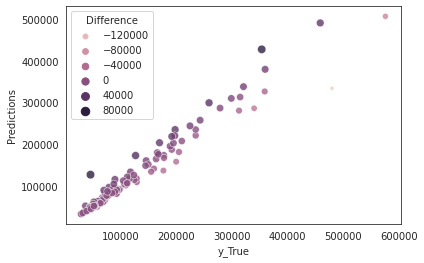

In [ ]:
# Errors Scatterplot
sns.scatterplot(data=performance, x='y_True', y='Predictions', hue='Difference', size='Difference', alpha=.8);

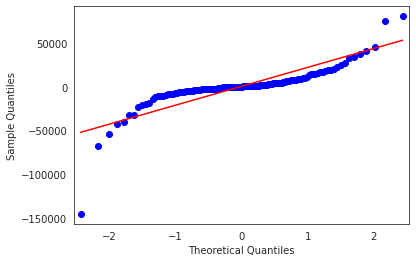

In [ ]:
# Errors QQPlot
sm.qqplot(performance.Difference, line='s');

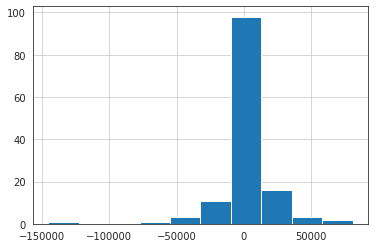

In [ ]:
performance.Difference.hist();

Concluimos nosso estudo com um modelo que explica a variação de aproximadamente 95% do dataset. Olhando para esses resultados, vemos que os outliers causam  ruído no modelo e que a pequena quantidade de observações no dataset também influenciam o resultado do modelo.

Como exemplo, temos a previsão do algumas marcas como o Porsche com uma diferença de quase R$150 mil, e sabemos que temos poucos carros de alguns fabricantes com uma variação bem grande, dificultando ao modelo chegar em um resultado mais próximo.

#***FIM***

In [ ]:
df_to_predict = pd.DataFrame({'ano_fabrica': [2019], 'anunciante_Concessionária': [0], 'anunciante_Loja': [1], 'anunciante_Pessoa Física': [0], 'automatico': [1], 'combustivel_DIESEL': [0],
 'combustivel_FLEX': [1], 'combustivel_GASOLINA': [0], 'combustivel_HÍBRIDO': [0], 'fabricante_AUDI': [0], 'fabricante_BMW': [0], 'fabricante_CHERY': [0], 'fabricante_CHEVROLET': [0],
 'fabricante_CITROEN': [0], 'fabricante_DODGE': [0], 'fabricante_FIAT': [0], 'fabricante_FORD': [0], 'fabricante_HONDA': [0], 'fabricante_HYUNDAI': [0], 'fabricante_JAC': [0], 'fabricante_JAGUAR': [0],
 'fabricante_JEEP': [1], 'fabricante_KIA': [0], 'fabricante_LAND ROVER': [0], 'fabricante_LEXUS': [0], 'fabricante_LIFAN': [0], 'fabricante_MERCEDES-BENZ': [0], 'fabricante_MINI': [0], 'fabricante_MITSUBISHI': [0],
 'fabricante_NISSAN': [0], 'fabricante_PEUGEOT': [0], 'fabricante_PORSCHE': [0], 'fabricante_RENAULT': [0], 'fabricante_SUZUKI': [0], 'fabricante_TOYOTA': [0], 'fabricante_VOLKSWAGEN': [0], 'fabricante_VOLVO': [0],
 'km': [7500], 'motor': [1.8], 'regiao_Centro-Oeste': [0], 'regiao_Nordeste': [1], 'regiao_Norte': [0], 'regiao_Sudeste': [0], 'regiao_Sul': [0]})

In [ ]:
df_to_predict = df_to_predict.reindex(columns=X_test.columns)

In [ ]:
#Previsão do modelo
previsao = best_model.predict(df_to_predict)
previsao = previsao.tolist()[0]
previsao = f' R$ { round( previsao , 2 ):,}'

previsao

' R$ 93,486.82'